# Declaration

## Declaration of variables and used libraries

In [7]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import os
from PIL import Image  ### conda install pillow  
import matplotlib.pyplot as plt
from itertools import chain

import pymrmr
import IPython
from IPython.core.debugger import set_trace
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import SimpleITK as sitk
from medpy.io import load
from radiomics import featureextractor
from sklearn.linear_model import Lasso
# import PyWavelets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import re


import Dclr_of_class_variables as DCV
import Dclr_of_functions as DF

# Master Thesis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6252243/

This thesis deals with a classification of glioma grade in high and low agressive tumours. For calculating features is used special radiomics library called PyRadiomics. Goal of this work is calculate all the features from PyRadiomics from different weightening sequence of MRI, then select the best features and choose a best classifier, that will provide the glioma grade. Another important task of this thesis is survival prediction - predicting number of days or years that the patient will survive after GTR-Gross Rotal Resection.

## Image import and ROI creation
In order to properly calculate features for classification of gliomas, the new mask-files were created that represented specific regions in tumours - regions of interest(ROI)
The first ROI was created  by merging the non-enhancing tumor and necrotic region
The second ROI was created by adding the tumor region with enhancememnt to the first region
The third ROI combined the second region with the area of edema
Using various ROI should help to distinguish the largely varying parts of tumour between grades


In [34]:
BRATS=DF.Create_Image_repository();
print('Succesful')

Succesful


In [35]:
DF.Create_ROI(BRATS);
print('Succesful')

Succesful


## Radiomics
The histogram-based features were computed from 128 bin histogram computed over the whole intensity range. 
The shape descriptors are not correlated features from radionomics library as Sphericity,Major Axis Length,Flatness...
The texture based descriptors are calculated from given matrixes:GLCM,GLSZM,GLRLM,NGTDM,GLDM.

In [36]:
extractor2=featureextractor.RadiomicsFeatureExtractor('D:/data/testovanie.yaml')
result_HGG_I=DF.Radionomics_structure(extractor2,BRATS,'ROI_I.nii.gz','HGG')
result_LGG_I=DF.Radionomics_structure(extractor2,BRATS,'ROI_I.nii.gz','LGG')
print('ROI_I finished')
result_HGG_II=DF.Radionomics_structure(extractor2,BRATS,'ROI_II.nii.gz','HGG')
result_LGG_II=DF.Radionomics_structure(extractor2,BRATS,'ROI_II.nii.gz','LGG')
print('ROI_II finished')
result_HGG_III=DF.Radionomics_structure(extractor2,BRATS,'ROI_III.nii.gz','HGG')
result_LGG_III=DF.Radionomics_structure(extractor2,BRATS,'ROI_III.nii.gz','LGG')
print('ROI_III finished')

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details


ROI_I finished
ROI_II finished
ROI_III finished


##  Z-score normalization and saving/reading CSV file
Feature values of the training cohort were normalized to z-scores for each feature across subjects as the different radiomics features have different units and range.
Now is necessary to divide samples in two classes- LG and HG and save them. 
As the calculation of features is computationally expensive is better to save the features after calculation as csv file and than, while tuning the algorithm, read features from csv.

In [ ]:
if not os.path.exists(DCV.newpath):
    os.makedirs(DCV.newpath)
    
count=0
for ROI_name in range(0,len(DCV.List_of_ROI_names)-1,2):
    DF.Saving_normalized_CSV(eval(DCV.List_of_ROI_names[ROI_name]),eval(DCV.List_of_ROI_names[ROI_name+1]),DCV.ROI_list[count])
    count=count+1

In [43]:
folder=os.listdir(DCV.newpath)
    
ROI_I= pd.read_csv(DF.Add_folder(DCV.newpath,folder[0]),header=[0,1])
ROI_II= pd.read_csv(DF.Add_folder(DCV.newpath,folder[1]),header=[0,1])
ROI_III= pd.read_csv(DF.Add_folder(DCV.newpath,folder[2]),header=[0,1])
target=ROI_I.iloc[:,0]
No_HG=target.value_counts()[1]

if 'BRATS' not in globals():
    BRATS=DF.Create_Image_repository();

## Vyobrazenie parametrov
The  random forest with gini impurity was used to select features useful for classifying glioma grades in the training cohort. In this moment for classification are used features calculated only from ROI I

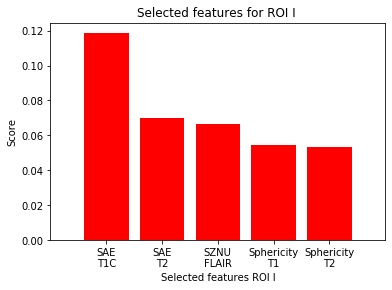

In [46]:
model = ExtraTreesClassifier(n_estimators=2000,criterion='gini')
model.fit(ROI_I.iloc[:,1:21], target)
importances = model.feature_importances_

indic = np.argsort(importances)[::-1]
ticks=DF.Create_ticks(ROI_I,indic)
pom=importances[indic]
indices=pom[0:5]
plt.figure()
plt.title("Selected features for ROI I ")
plt.bar(np.arange(5), indices,color="r")
plt.xticks(np.arange(5),(ticks))
plt.xlim([-1,5])
plt.xlabel("Selected features ROI I")
plt.ylabel("Score")

plt.savefig('Selected_features_ROI_I.svg')
plt.show()

number_of_selected_features=7
Indices=indic[0:number_of_selected_features]+1

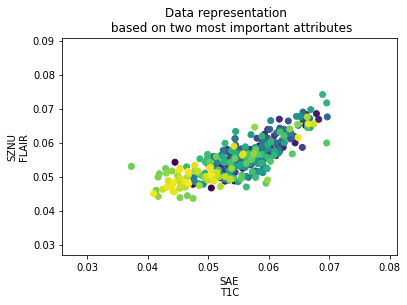

In [198]:
plt.scatter(ROI_I.iloc[:,Indices[0]].values,ROI_I.iloc[:,Indices[1]].values,c=ROI_I.iloc[:,Indices[1]].axes[0])
plt.title("Data representation  \n based on two most important attributes")
plt.xlabel(ticks[0])
plt.ylabel(ticks[1])
plt.savefig('graph_ROI_I.svg')
plt.show()


## Training
According to information provided in multiple scientific articles dedicated to problem of automatic glioma grading, the best classifier for this task is random forest, as there are not enough data to train neural network.
To correctly evaluate classification, the accuracy in training cohort is calculated and then, using k-fold cross validation, the accuracy of testing cohort. 

In [47]:

X_train, X_test, y_train, y_test,idx1,idx2 = train_test_split(ROI_I.iloc[:,Indices],target,np.arange(len(target)), test_size=0.3)


In [51]:

clasifier= RandomForestClassifier(n_estimators=200,bootstrap = True,)
clasifier.fit(X_train, y_train)
print(f'Accuracy of training cohort: {clasifier.score(X_train, y_train)}')

y_pred = clasifier.predict(X_test)
rf_probs = clasifier.predict_proba(X_test)[:, 1]

print(f'Confusion Matrix: {confusion_matrix(y_test,y_pred)}')
print(f'Area under curve for random forest: {roc_auc_score(y_test, rf_probs)}')
print(f'Accuracy_score of testing cohort: {accuracy_score(y_test, y_pred)}')

scores = cross_val_score(clasifier,ROI_I.iloc[:,Indices],target,cv=10)
print(f'Cross_val_accuracy: {np.mean(scores)}')

Accuracy of training cohort: 1.0
Confusion Matrix: [[19 11]
 [ 3 68]]
Area under curve for random forest: 0.9204225352112676
Accuracy_score of testing cohort: 0.8613861386138614
Cross_val_accuracy: 0.8804812834224599


In [52]:
print(scores)

[0.85294118 0.94117647 0.88235294 0.88235294 0.88235294 0.78787879
 0.90909091 0.84848485 0.87878788 0.93939394]


## Errors evaluation
Detailed analysis of incorectly clasified samples is performed in different open-source software as ImageJ or VV4


In [53]:
y = 0 
Output = []  
for x in y_pred: 
    if x != y_test.values[y]: 
        Output.append(y) 
    y = y + 1
print(f'Missclasified: {idx2[Output]}')

Missclasified: [310 314 271 324 175 106 303 301   1 333 276 296 293 284]


In [54]:
misclass_LGG=[]
misclass_HGG=[]
for x in idx2[Output]:
    if (No_HG-1)< x:
         misclass_LGG.append(x-No_HG-1)
    else :
        misclass_HGG.append(x)
print(f'Missclasified LGG: {misclass_LGG}')
print(f'Missclasified HGG: {misclass_HGG}')

Missclasified LGG: [49, 53, 10, 63, 42, 40, 72, 15, 35, 32, 23]
Missclasified HGG: [175, 106, 1]


In [55]:
print('BAD HGG IMAGE')
for bad_HGG_image in range(No_HG):
    if bad_HGG_image in misclass_HGG:
        print(BRATS[0].type[0].grade[bad_HGG_image].foldername)
        
        
print('BAD LGG IMAGE')
for bad_LGG_image in range(No_HG):
    if bad_LGG_image in misclass_LGG:
        print(BRATS[0].type[1].grade[bad_LGG_image].foldername)

BAD HGG IMAGE
Brats18_2013_11_1
Brats18_CBICA_AXO_1
Brats18_TCIA02_151_1
BAD LGG IMAGE
Brats18_TCIA09_141_1
Brats18_TCIA09_402_1
Brats18_TCIA10_130_1
Brats18_TCIA10_299_1
Brats18_TCIA10_325_1
Brats18_TCIA10_393_1
Brats18_TCIA10_410_1
Brats18_TCIA10_628_1
Brats18_TCIA10_639_1
Brats18_TCIA13_618_1
Brats18_TCIA13_650_1


# Survival prediction
All patients in this dataset died in scope of few years except 2 subjects. The goal is to estimate number of years this subjects have based on age and calculated radiomic features.
One type of analysis is classifying subject in three groups based on numbers of years they lived after being diagnosed with GBM - Glioblastoma multiforme.
Second type of analysis will be prediction values.

##  Classification according to number of years
Separation of data into 3 classes and joining two different datasets in order to combine given and calculated information are necessary steps in preprocessing data for classification.

In [56]:
survival_table = pd.read_csv("D:\\Data\\Nove_datasety\\Survival_data\\survival_data.csv",sep=',',converters={"Survival" : lambda x: 0 if x == "NA" else int(x)},index_col ="ResectionStatus")
valid_survivors=survival_table.loc["GTR"] 
survival_class=[]

for j in range(len(valid_survivors)):
    if valid_survivors.Survival.iloc[j] <=365:
        survival_class.append(0) # less than 1 year
    if (valid_survivors.Survival.iloc[j] >365 and valid_survivors.Survival.iloc[j]<=365*2):
        survival_class.append(1) # less than 2 year but more than 1 year
    if valid_survivors.Survival.iloc[j] >365*2:
        survival_class.append(2) # more than 3 year



In [57]:
newDF = pd.DataFrame(columns=ROI_I.columns[Indices].values, index=valid_survivors.Brats18ID.values)

for j in range(len(BRATS[0].type[0].grade)):
    if BRATS[1].type[0].grade[j].foldername in valid_survivors.Brats18ID.values:
        newDF.loc[BRATS[1].type[0].grade[j].foldername] = ROI_I.iloc[j,Indices].values

survivors_table=valid_survivors.set_index('Brats18ID').join(newDF);

In [58]:
X_train, X_test, y_train, y_test = train_test_split(survivors_table.values,survival_class,test_size=0.3)
clasifier= RandomForestClassifier(n_estimators=200,bootstrap = True,)
clasifier.fit(X_train, y_train)
print(f'Accuracy of training cohort: {clasifier.score(X_train, y_train)}')

y_pred = clasifier.predict(X_test)
rf_probs = clasifier.predict_proba(X_test)[:, 1]

print(f'Confusion Matrix: {confusion_matrix(y_test,y_pred)}')
print(f'Accuracy_score of testing cohort: {accuracy_score(y_test, y_pred)}')

scores = cross_val_score(clasifier,survivors_table.values,survival_class,cv=5)
print(f'Cross_val_accuracy: {np.mean(scores)}')

Accuracy of training cohort: 1.0
Confusion Matrix: [[16  0  0]
 [ 0 13  0]
 [ 0  1  2]]
Accuracy_score of testing cohort: 0.96875
Cross_val_accuracy: 0.9708589655958078


## Regresion
As we have too little subject for accurate regresion, we have to regularization to obtain correct results.

In [62]:
alpha=1
regr=Lasso(alpha)
regr.fit(X_train,y_train)
pred=regr.predict(X_test) #predikovany y
w=regr.coef_
print(f'RMS: {np.sqrt(np.mean((y_test-pred)**2))}')

RMS: 0.26407783680148583
